# Preços de imóveis em João Pessoa

## Introdução

Esta análise se baseia na raspagem de dados na OLX para a pesquisa <a href = "https://www.olx.com.br/brasil?q=im%C3%B3veis%20em%20jo%C3%A3o%20pessoa&o=1">imóveis em joão pessoa</a>, seguida de análise exploratória desses dados.

São empregadas para tanto as seguintes bibliotecas:

- Requests para a realização de requisições HTTP;

- time para intervalos entre requisições;

- random para randomizar intervalos(otimização);

- tqdm para controle de tempo;

- BeautifulSoup para a extração de dados do html das páginas;

- csv para salvar informações da última sessão de scraping;

- re para a filtragem mais fina desses dados;

- Pandas para manipulação de dados em dataframes.

## 1. Importar bibliotecas

In [1]:
import requests
import time
from random import uniform
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
import csv
import re
import pandas as pd
import plotly.express as px

## 2. Web scraping

A primeira parte de nossa análise será a extração de dados por scraping do site da OLX. Para tanto procederemos assim:

1. Inicialmente varremos as páginas de pesquisa à procura dos links de cada um dos produtos;

2. Depois, para cada produto, faremos a raspagem de suas informações em sua própria página.

In [2]:
base_url = 'https://www.olx.com.br/brasil?q=imoveis%20em%20joao%20pessoa'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}

csv_filename = 'paginas_processadas.csv'
detailed_csv_filename = 'detalhes_paginas_processadas.csv'
products_filename = 'produtos_coletados.csv'

# Função para ler produtos já coletados
def get_existing_products():
    existing_products = set()
    try:
        with open(products_filename, 'r', encoding='utf-8') as f:
            reader = csv.DictReader(f)
            for row in reader:
                existing_products.add(row['url'])
    except FileNotFoundError:
        pass
    return existing_products

# Função para ler páginas processadas
def get_processed_pages():
    processed_pages = set()
    try:
        with open(detailed_csv_filename, 'r', encoding='utf-8') as f:
            reader = csv.DictReader(f)
            for row in reader:
                processed_pages.add(int(row['numero_pagina']))
        return processed_pages, max(processed_pages) if processed_pages else 0
    except FileNotFoundError:
        return set(), 0

# Obter dados existentes
existing_products = get_existing_products()
processed_pages, last_processed_page = get_processed_pages()

print(f"Ultima pagina processada: {last_processed_page}")
print(f"Produtos existentes: {len(existing_products)}")

# Definir intervalo de verificação
start_check = 1
end_check = last_processed_page + 10 if last_processed_page > 0 else 10
pages_to_check = list(range(start_check, end_check + 1))

products_links = []
processed_pages_info = []
successful_pages = 0

# Processamento único com verificação inteligente
pbar = tqdm(pages_to_check, desc="Processando paginas", unit="pagina",
            bar_format='{desc}: {n_fmt}/{total_fmt} [Tempo restante: {remaining}]')

for page in pbar:
    url = f"{base_url}&o={page}"
    pbar.set_postfix_str(f"Pag {page} | Novos: {len(products_links)}")

    try:
        response = requests.get(url, headers=headers, timeout=15)
        
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            
            # Verificar se página tem resultados
            if soup.find('div', class_='empty-list') or 'Nenhum resultado encontrado' in response.text:
                pbar.set_postfix_str(f"Pag {page} sem resultados")
                page_links = []
            else:
                # Coletar links da página
                page_links = []
                for link in soup.find_all('a', class_='olx-adcard__link'):
                    href = link.get('href')
                    if href and href.startswith('http') and href not in existing_products:
                        page_links.append(href)
                        products_links.append({
                            'url': href,
                            'pagina': page,
                            'data_coleta': time.strftime('%Y-%m-%d %H:%M:%S')
                        })
                
                if page_links:
                    successful_pages += 1
                    pbar.set_postfix_str(f"Pag {page} | +{len(page_links)} novos")
                else:
                    pbar.set_postfix_str(f"Pag {page} | Sem novos produtos")

            # Registrar informação da página (mesmo sem novos produtos)
            processed_pages_info.append({
                'numero_pagina': page,  # Corrigido para match com fieldnames
                'status': "Sucesso" if response.status_code == 200 and page_links else "Sem novos",
                'produtos_encontrados': len(page_links),  # Corrigido para match com fieldnames
                'data_processamento': time.strftime('%Y-%m-%d %H:%M:%S')
            })

        else:
            pbar.set_postfix_str(f"Pag {page} erro: {response.status_code}")
            processed_pages_info.append({
                'numero_pagina': page,
                'status': f"Erro {response.status_code}",
                'produtos_encontrados': 0,
                'data_processamento': time.strftime('%Y-%m-%d %H:%M:%S')
            })
            
    except Exception as e:
        pbar.set_postfix_str(f"Pag {page} erro: {str(e)[:20]}...")
        processed_pages_info.append({
            'numero_pagina': page,
            'status': f"Erro: {str(e)[:20]}...",
            'produtos_encontrados': 0,
            'data_processamento': time.strftime('%Y-%m-%d %H:%M:%S')
        })
    
    time.sleep(uniform(1, 3))

pbar.close()

# Salvar resultados se houver novos produtos
if products_links or processed_pages_info:
    # Função para append em CSV
    def append_to_csv(filename, data_list, fieldnames):
        try:
            with open(filename, 'r', encoding='utf-8') as f:
                has_header = bool(csv.Sniffer().has_header(f.read(1024)))
        except:
            has_header = False
        
        with open(filename, 'a', newline='', encoding='utf-8') as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            if not has_header:
                writer.writeheader()
            for data in data_list:
                writer.writerow(data)

    # Salvar produtos
    if products_links:
        append_to_csv(products_filename, products_links, ['url', 'pagina', 'data_coleta'])
    
    # Salvar detalhes das páginas - CORRIGIDO fieldnames
    append_to_csv(detailed_csv_filename, processed_pages_info, 
                 ['numero_pagina', 'status', 'produtos_encontrados', 'data_processamento'])
    
    # Salvar resumo
    first_page = min(p['numero_pagina'] for p in processed_pages_info)
    last_page = max(p['numero_pagina'] for p in processed_pages_info)
    
    summary_data = [{
        'primeira_pagina': first_page,
        'ultima_pagina': last_page,
        'paginas_processadas_sucesso': successful_pages,
        'total_produtos_coletados': len(products_links),
        'total_paginas_processadas': len(processed_pages_info),
        'data_execucao': time.strftime('%Y-%m-%d %H:%M:%S')
    }]
    
    append_to_csv(csv_filename, summary_data, 
                 ['primeira_pagina', 'ultima_pagina', 'paginas_processadas_sucesso', 
                  'total_produtos_coletados', 'total_paginas_processadas', 'data_execucao'])

print(f"Processamento concluido!")
print(f"Paginas verificadas: {len(pages_to_check)}")
print(f"Novos produtos: {len(products_links)}")
print(f"Paginas com novos produtos: {successful_pages}")

Ultima pagina processada: 0
Produtos existentes: 0


Processando paginas: 0/10 [Tempo restante: ?]

Processamento concluido!
Paginas verificadas: 10
Novos produtos: 500
Paginas com novos produtos: 10


Agora que coletamos links de imóveis, vamos investigá-los individualmente:

In [3]:
# Configurações
CSV_FILE = 'data.csv'
existing_links = set()
all_products = []

try:
    # Tentar carregar dados existentes
    existing_df = pd.read_csv(CSV_FILE)
    existing_links = set(existing_df['link'].tolist())
    all_products = existing_df.to_dict('records')
    print(f"Encontrados {len(existing_links)} produtos no arquivo existente.")
except FileNotFoundError:
    print("Arquivo CSV não encontrado. Iniciando extração completa.")
    existing_df = pd.DataFrame()
except Exception as e:
    print(f"Erro ao ler arquivo existente: {e}")
    print("Iniciando extração do zero.")
    existing_df = pd.DataFrame()

# Identificar apenas os links novos
new_links = [link for link in products_links if link.get('url') not in existing_links]
print(f"Encontrados {len(new_links)} novos links para extrair.")

# Processar apenas os links novos se houver
if new_links:
    pbar = tqdm(total=len(new_links), desc="Processando NOVOS produtos", unit="produto", 
                bar_format='{desc}: {n_fmt}/{total_fmt} [Tempo restante: {remaining}]')

    for i, link in enumerate(new_links, 1):
        try:
            product_response = requests.get(link.get('url'), headers=headers, timeout=10)

            if product_response.status_code == 200:
                product_soup = BeautifulSoup(product_response.text, 'html.parser')

                # Extração dos dados (mantive sua lógica original)
                title_elem = product_soup.find('span', class_='olx-text olx-text--title-medium olx-text--block ad__sc-1l883pa-2 bdcWAn')
                title = title_elem.text.strip() if title_elem else 'Não especificado'

                location_div = product_soup.find('div', id='location')
                if location_div:
                    location_elem = location_div.find('span', class_='olx-text olx-text--body-small olx-text--block olx-text--semibold olx-color-neutral-110')
                    location = location_elem.text.strip() if location_elem else 'Não especificado'
                else:
                    location = 'Não especificado'
                
                price_div = product_soup.find('div', id='price-box-container')
                if price_div:
                    price_elem = price_div.find('span', {'data-ds-component': 'DS-Text'})
                    price = price_elem.text.strip() if price_elem else 'Não especificado'
                    
                    product_type_elem = price_div.find('span', class_='olx-badge olx-badge--neutral olx-badge--small olx-badge--rectangle')
                    product_type = product_type_elem.text.strip() if product_type_elem else "Não especificado"
                else:
                    price = 'Não especificado'
                    product_type = "Não especificado"

                product_data = {
                    'date': time.strftime('%Y-%m-%d %H:%M:%S'),
                    'title': title,
                    'location': location,
                    'price': price,
                    'product_type': product_type,
                    'link': link.get('url')
                }

                all_products.append(product_data)
                
                # Atualizar informações na barra de progresso
                pbar.set_postfix_str(f"Último: {title[:20]}...")

            else:
                pbar.set_postfix_str(f"Erro: Status {product_response.status_code}")

        except requests.exceptions.RequestException as e:
            pbar.set_postfix_str(f"Erro de rede: {str(e)[:20]}...")
        except Exception as e:
            pbar.set_postfix_str(f"Erro inesperado: {str(e)[:20]}...")
        
        # Atualizar o progresso
        pbar.update(1)
        time.sleep(uniform(1, 3))

    pbar.close()
else:
    print("Nenhum novo link encontrado. Nada para processar.")

# Salvar todos os dados (antigos + novos) no CSV
if all_products:
    try:
        df = pd.DataFrame(all_products)
        
        # Remover possíveis duplicatas (segurança extra)
        df = df.drop_duplicates(subset=['link'], keep='last')
        
        # Ordenar por data (opcional)
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date', ascending=False)
        
        # Salvar no CSV
        df.to_csv(CSV_FILE, index=False, encoding='utf-8')
        
        print(f"Extração concluída! Total de produtos no dataset: {len(df)}")
        print(f"Novos produtos adicionados: {len(new_links)}")
    except Exception as e:
        print(f"Erro ao salvar dados: {e}")
else:
    print("Nenhum produto para salvar.")

Arquivo CSV não encontrado. Iniciando extração completa.
Encontrados 500 novos links para extrair.


Processando NOVOS produtos: 0/500 [Tempo restante: ?]

Extração concluída! Total de produtos no dataset: 490
Novos produtos adicionados: 500


Para o restante da análise, incluindo a limpeza e o tratamento dos dados, passamos as informações extraídas para um dataframe, de modo a empregar os artifícios da biblioteca Pandas.

## 3. Limpeza e tratamento

In [4]:
df = pd.read_csv('data.csv')

In [5]:
df

,date,title,location,price,product_type,link
0,2025-09-02 23:53:38,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58062187",R$ 58.295,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
1,2025-09-02 23:53:34,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58062157",R$ 58.340,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
2,2025-09-02 23:53:31,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58084145",R$ 52.666,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
3,2025-09-02 23:53:29,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58069100",R$ 47.605,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
4,2025-09-02 23:53:24,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58062069",R$ 85.477,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
...,...,...,...,...,...,...
485,2025-09-02 23:25:38,Imoveis exclusivos,"Manaíra, João Pessoa, PB, 58038142",R$ 650.000,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
486,2025-09-02 23:25:35,Imóveis na Planta,"Jardim Oceania, João Pessoa, PB, 58037030",R$ 416.234,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
487,2025-09-02 23:25:32,Vendo Imóveis de Alto padrão a Beira Mar de In...,"Ipês, João Pessoa, PB, 58028530",R$ 480.000,Venda,https://pb.olx.com.br/paraiba/imoveis/vendo-im...
488,2025-09-02 23:25:29,Imóveis para repasse possuem 62 m² com 02 quar...,"João Pessoa, PB, 58068103",R$ 42.000,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          490 non-null    object
 1   title         490 non-null    object
 2   location      490 non-null    object
 3   price         490 non-null    object
 4   product_type  490 non-null    object
 5   link          490 non-null    object
dtypes: object(6)
memory usage: 23.1+ KB


Algumas pessoas usaram indevidamente a OLX para disponibilizar seus contatos, a fim de realizar serviços por fora do aplicativo. Podemos remover as linhas correspondentes a esses erros usando verificação por expressão regular na linha de preços, e aproveitar, inclusive, para corrigir a apresentação dos preços para um valor numérico:

In [7]:
# Filtrar para regex correto
price_regex = r'R\$\s*\d{1,3}(?:\.\d{3})*(?:,\d{1,2})?|R\$\s*\d+(?:,\d{1,2})?'
price_mask = df['price'].apply(lambda x: bool(re.search(price_regex, str(x))))
df = df[price_mask]

In [8]:
df

,date,title,location,price,product_type,link
0,2025-09-02 23:53:38,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58062187",R$ 58.295,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
1,2025-09-02 23:53:34,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58062157",R$ 58.340,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
2,2025-09-02 23:53:31,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58084145",R$ 52.666,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
3,2025-09-02 23:53:29,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58069100",R$ 47.605,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
4,2025-09-02 23:53:24,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58062069",R$ 85.477,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
...,...,...,...,...,...,...
485,2025-09-02 23:25:38,Imoveis exclusivos,"Manaíra, João Pessoa, PB, 58038142",R$ 650.000,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
486,2025-09-02 23:25:35,Imóveis na Planta,"Jardim Oceania, João Pessoa, PB, 58037030",R$ 416.234,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
487,2025-09-02 23:25:32,Vendo Imóveis de Alto padrão a Beira Mar de In...,"Ipês, João Pessoa, PB, 58028530",R$ 480.000,Venda,https://pb.olx.com.br/paraiba/imoveis/vendo-im...
488,2025-09-02 23:25:29,Imóveis para repasse possuem 62 m² com 02 quar...,"João Pessoa, PB, 58068103",R$ 42.000,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...


In [9]:
df['price'] = (
    df['price']
    .str.replace(r'R\$\s*|[.]', '', regex=True)
    .str.replace(',', '.', regex=False)
    .astype('float64')
)

/tmp/ipykernel_14313/1789600710.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'] = (


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 470 entries, 0 to 489
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          470 non-null    object 
 1   title         470 non-null    object 
 2   location      470 non-null    object 
 3   price         470 non-null    float64
 4   product_type  470 non-null    object 
 5   link          470 non-null    object 
dtypes: float64(1), object(5)
memory usage: 25.7+ KB


In [11]:
df

,date,title,location,price,product_type,link
0,2025-09-02 23:53:38,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58062187",58295.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
1,2025-09-02 23:53:34,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58062157",58340.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
2,2025-09-02 23:53:31,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58084145",52666.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
3,2025-09-02 23:53:29,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58069100",47605.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
4,2025-09-02 23:53:24,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58062069",85477.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
...,...,...,...,...,...,...
485,2025-09-02 23:25:38,Imoveis exclusivos,"Manaíra, João Pessoa, PB, 58038142",650000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
486,2025-09-02 23:25:35,Imóveis na Planta,"Jardim Oceania, João Pessoa, PB, 58037030",416234.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
487,2025-09-02 23:25:32,Vendo Imóveis de Alto padrão a Beira Mar de In...,"Ipês, João Pessoa, PB, 58028530",480000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/vendo-im...
488,2025-09-02 23:25:29,Imóveis para repasse possuem 62 m² com 02 quar...,"João Pessoa, PB, 58068103",42000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...


Outra coisa que faremos é transformar a coluna ``location`` em uma coluna contendo apenas os CEPs de cada imóvel (já aproveitamos para deixar o CEP correto para a cidade de João Pessoa):

In [12]:
df = df.rename(columns = {'location': 'cep'})

In [13]:
df

,date,title,cep,price,product_type,link
0,2025-09-02 23:53:38,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58062187",58295.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
1,2025-09-02 23:53:34,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58062157",58340.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
2,2025-09-02 23:53:31,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58084145",52666.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
3,2025-09-02 23:53:29,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58069100",47605.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
4,2025-09-02 23:53:24,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,"João Pessoa, PB, 58062069",85477.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
...,...,...,...,...,...,...
485,2025-09-02 23:25:38,Imoveis exclusivos,"Manaíra, João Pessoa, PB, 58038142",650000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
486,2025-09-02 23:25:35,Imóveis na Planta,"Jardim Oceania, João Pessoa, PB, 58037030",416234.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
487,2025-09-02 23:25:32,Vendo Imóveis de Alto padrão a Beira Mar de In...,"Ipês, João Pessoa, PB, 58028530",480000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/vendo-im...
488,2025-09-02 23:25:29,Imóveis para repasse possuem 62 m² com 02 quar...,"João Pessoa, PB, 58068103",42000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...


In [14]:
cep_regex = r'(58\d{6})'

df['cep'] = df['cep'].str.extract(cep_regex)
df = df.dropna(subset=['cep']).copy()
df = df.reset_index(drop = True)
df

,date,title,cep,price,product_type,link
0,2025-09-02 23:53:38,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,58062187,58295.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
1,2025-09-02 23:53:34,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,58062157,58340.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
2,2025-09-02 23:53:31,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,58084145,52666.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
3,2025-09-02 23:53:29,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,58069100,47605.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
4,2025-09-02 23:53:24,Oportunidade Única em JOAO PESSOA - PB | Tipo:...,58062069,85477.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
...,...,...,...,...,...,...
459,2025-09-02 23:25:38,Imoveis exclusivos,58038142,650000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
460,2025-09-02 23:25:35,Imóveis na Planta,58037030,416234.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
461,2025-09-02 23:25:32,Vendo Imóveis de Alto padrão a Beira Mar de In...,58028530,480000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/vendo-im...
462,2025-09-02 23:25:29,Imóveis para repasse possuem 62 m² com 02 quar...,58068103,42000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...


Em ``title``, convém remover vírgulas e pontuações, bem como normalizar o texto para lower case:

In [15]:
df['title'] = df['title'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df['title'] = df['title'].apply(lambda x: x.lower())

In [16]:
df

,date,title,cep,price,product_type,link
0,2025-09-02 23:53:38,oportunidade única em joao pessoa pb tipo ap...,58062187,58295.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
1,2025-09-02 23:53:34,oportunidade única em joao pessoa pb tipo ap...,58062157,58340.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
2,2025-09-02 23:53:31,oportunidade única em joao pessoa pb tipo ap...,58084145,52666.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
3,2025-09-02 23:53:29,oportunidade única em joao pessoa pb tipo ap...,58069100,47605.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
4,2025-09-02 23:53:24,oportunidade única em joao pessoa pb tipo ap...,58062069,85477.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
...,...,...,...,...,...,...
459,2025-09-02 23:25:38,imoveis exclusivos,58038142,650000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
460,2025-09-02 23:25:35,imóveis na planta,58037030,416234.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
461,2025-09-02 23:25:32,vendo imóveis de alto padrão a beira mar de in...,58028530,480000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/vendo-im...
462,2025-09-02 23:25:29,imóveis para repasse possuem 62 m² com 02 quar...,58068103,42000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...


Vale a pena testar para duplicatas e valores nulos:

In [17]:
df.duplicated().sum()

np.int64(0)

Removemos:

In [18]:
df.drop_duplicates(inplace = True)
df = df.reset_index(drop = True)

df

,date,title,cep,price,product_type,link
0,2025-09-02 23:53:38,oportunidade única em joao pessoa pb tipo ap...,58062187,58295.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
1,2025-09-02 23:53:34,oportunidade única em joao pessoa pb tipo ap...,58062157,58340.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
2,2025-09-02 23:53:31,oportunidade única em joao pessoa pb tipo ap...,58084145,52666.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
3,2025-09-02 23:53:29,oportunidade única em joao pessoa pb tipo ap...,58069100,47605.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
4,2025-09-02 23:53:24,oportunidade única em joao pessoa pb tipo ap...,58062069,85477.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
...,...,...,...,...,...,...
459,2025-09-02 23:25:38,imoveis exclusivos,58038142,650000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
460,2025-09-02 23:25:35,imóveis na planta,58037030,416234.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
461,2025-09-02 23:25:32,vendo imóveis de alto padrão a beira mar de in...,58028530,480000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/vendo-im...
462,2025-09-02 23:25:29,imóveis para repasse possuem 62 m² com 02 quar...,58068103,42000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...


In [19]:
df.duplicated().sum()

np.int64(0)

In [20]:
df.isnull().sum()

date            0
title           0
cep             0
price           0
product_type    0
link            0
dtype: int64

Tudo certo!

Vamos a uma análise inicial dos nossos dados:

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464 entries, 0 to 463
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          464 non-null    object 
 1   title         464 non-null    object 
 2   cep           464 non-null    object 
 3   price         464 non-null    float64
 4   product_type  464 non-null    object 
 5   link          464 non-null    object 
dtypes: float64(1), object(5)
memory usage: 21.9+ KB


In [22]:
df.nunique()

date            464
title           169
cep             249
price           352
product_type      2
link            464
dtype: int64

In [23]:
df['price'].describe()

count    4.640000e+02
mean     6.144710e+05
std      1.133105e+06
min      8.000000e+02
25%      7.269325e+04
50%      2.792830e+05
75%      7.660000e+05
max      1.500000e+07
Name: price, dtype: float64

In [24]:
total = df['cep'].value_counts().sum()

df['cep'].value_counts().apply(lambda x: f"{(x/total) * 100}%")

cep
58046110     3.8793103448275863%
58037030     3.6637931034482754%
58045010     2.8017241379310347%
58068200      2.586206896551724%
58069472     2.3706896551724137%
                    ...         
58101650    0.21551724137931033%
58075020    0.21551724137931033%
58025430    0.21551724137931033%
58038142    0.21551724137931033%
58028530    0.21551724137931033%
Name: count, Length: 249, dtype: object

Notamos uma dispersão muito grande dos valores dos preços. Para melhorar a visualização, vamos fazer uma extração desses outliers:

In [25]:
df_numeric = df.select_dtypes(include = 'float64')

In [26]:
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)

IQR = Q3 - Q1

print(IQR)

price    693306.75
dtype: float64


In [27]:
print(Q1 - 1.5 * IQR)
print(Q3 + 1.5 * IQR)

price   -967266.875
dtype: float64
price    1805960.125
dtype: float64


In [28]:
outlier_mask = ((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR)))

In [29]:
df_outliers = df[outlier_mask.any(axis = 1)]
df_outliers = df_outliers.reset_index(drop = True)

In [30]:
df_outliers

,date,title,cep,price,product_type,link
0,2025-09-02 23:43:37,apartamento para venda em joão pessoa cabo bra...,58045010,4490000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/apartame...
1,2025-09-02 23:43:33,apartamento para venda em joão pessoa cabo bra...,58045010,2890000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/apartame...
2,2025-09-02 23:42:40,apartamento para venda em joão pessoa cabo bra...,58045010,4490000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/apartame...
3,2025-09-02 23:40:18,apartamento para venda em joão pessoa conjunto...,58031270,2061879.0,Venda,https://pb.olx.com.br/paraiba/imoveis/apartame...
4,2025-09-02 23:39:39,apartamento para venda em joão pessoa brisamar...,58033370,2200000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/apartame...
5,2025-09-02 23:39:24,apartamento para venda em joão pessoa altiplan...,58046170,2400000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/apartame...
6,2025-09-02 23:37:55,cobertura para venda em joão pessoa cabo branc...,58045010,2535900.0,Venda,https://pb.olx.com.br/paraiba/imoveis/cobertur...
7,2025-09-02 23:37:24,apartamento para venda em joão pessoa altiplan...,58046092,3134537.0,Venda,https://pb.olx.com.br/paraiba/imoveis/apartame...
8,2025-09-02 23:37:11,apartamento para venda em joão pessoa jardim o...,58037603,2503117.0,Venda,https://pb.olx.com.br/paraiba/imoveis/apartame...
9,2025-09-02 23:37:03,apartamento para venda em joão pessoa brisamar...,58033130,2400000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/apartame...


In [31]:
df = df[~outlier_mask.any(axis = 1)]
df = df.reset_index(drop = True)

In [32]:
df

,date,title,cep,price,product_type,link
0,2025-09-02 23:53:38,oportunidade única em joao pessoa pb tipo ap...,58062187,58295.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
1,2025-09-02 23:53:34,oportunidade única em joao pessoa pb tipo ap...,58062157,58340.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
2,2025-09-02 23:53:31,oportunidade única em joao pessoa pb tipo ap...,58084145,52666.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
3,2025-09-02 23:53:29,oportunidade única em joao pessoa pb tipo ap...,58069100,47605.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
4,2025-09-02 23:53:24,oportunidade única em joao pessoa pb tipo ap...,58062069,85477.0,Venda,https://pb.olx.com.br/paraiba/imoveis/oportuni...
...,...,...,...,...,...,...
428,2025-09-02 23:25:38,imoveis exclusivos,58038142,650000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
429,2025-09-02 23:25:35,imóveis na planta,58037030,416234.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...
430,2025-09-02 23:25:32,vendo imóveis de alto padrão a beira mar de in...,58028530,480000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/vendo-im...
431,2025-09-02 23:25:29,imóveis para repasse possuem 62 m² com 02 quar...,58068103,42000.0,Venda,https://pb.olx.com.br/paraiba/imoveis/imoveis-...


In [33]:
df.describe(include = 'float64')

,price
count,4.330000e+02
mean,3.985358e+05
std,4.216699e+05
min,8.000000e+02
25%,7.165400e+04
50%,9.600000e+04
75%,6.490000e+05
max,1.800000e+06


Vejamos quanto de nossa análise abrangeu entre vendas e aluguéis:

In [34]:
df['product_type'].value_counts()

product_type
Venda      428
Aluguel      5
Name: count, dtype: int64

Para esta análise, ocupar-nos-emos das vendas apenas:

In [35]:
df = df[df['product_type'] == 'Venda']

In [36]:
df = df.reset_index(drop = True)

## 4. Visualização

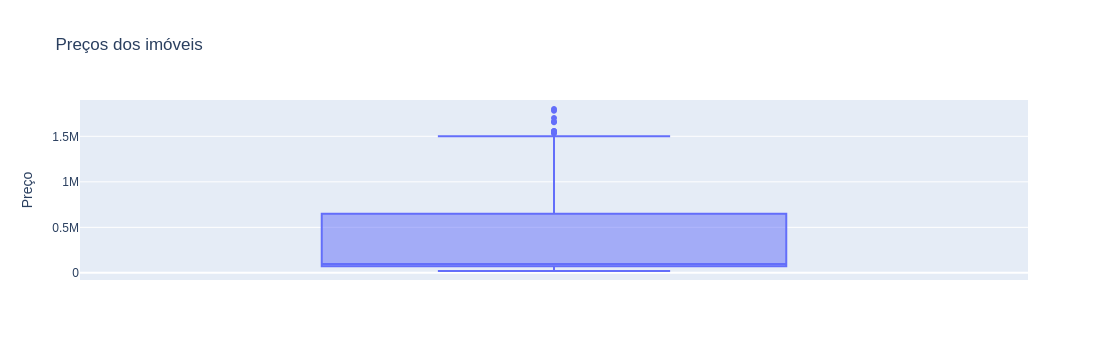

In [37]:
box_price = px.box(
    df,
    y = 'price',
    title = 'Preços dos imóveis',
)

box_price.update_layout(
    yaxis_title = 'Preço'
)

box_price.show()

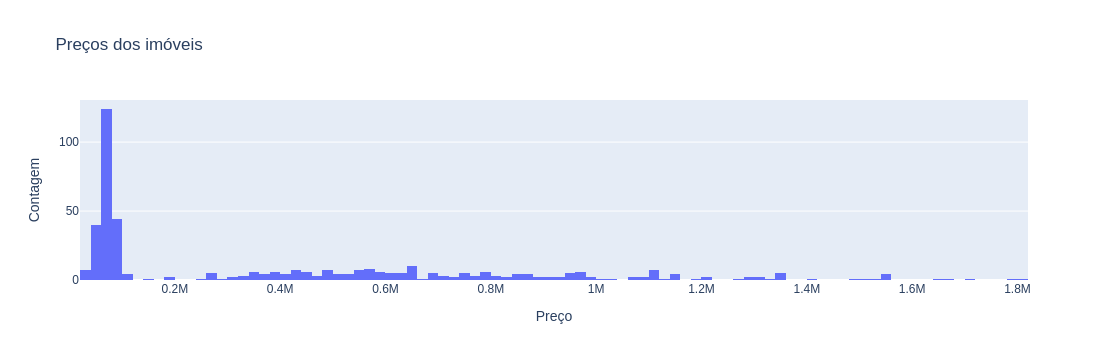

In [38]:
hist_price = px.histogram(
    df['price'].value_counts().reset_index(),
    x = 'price',
    y = 'count',
    nbins = 100,
    title = 'Preços dos imóveis',
)

hist_price.update_layout(
    xaxis_title = 'Preço',
    yaxis_title = 'Contagem'
)

hist_price.show()

## 5. Conclusões

Preços de venda de imóveis em João Pessoa na OLX concentram-se, à exceção de outliers, em torno de uma distribuição normal deslocada.